# Topical Lectures April 2021
## Drone control, part 3: basic control
Andreas Freise, Bas Swinkels 13.04.2021

In this notebook, we will, step by step, develop the control for the drone. We will define and test functions that take position and velocity information from the drone and compute `feedback' signals, i.e. new voltages for both drone motors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import module
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# This time we want inline plotting (non-interactive)
%matplotlib inline

# Don't forget to set the name string to your own name
MyName = "Joran"

First we can write a utiity function that uses the parameters from the system identificaition tasks in order to compensate for the small differences between different drones. Bu using this function to apply our feedback signal, we should be able to write control functions ignoring these details.

In [2]:
# we apply the drone parameters found in the system identification task
V_left_offset = -0.011250000000001564
V_hover = 0.5056685561853952
V_max = 5.130825001742341
V_min = -5


# This function take voltages for the left and right rotor and applies the previously 
# measured parameters for corrections such that for V_left-V_right=0 we have a 
# balanced and hovering drone.
# Note that the naive clipping of the feedback signal at V_min and V_max might not
# be the best solution for more advanced control loops, but it should work for now.
def set_v(drone, _V_left, _V_right):
    V_left =  np.clip(V_hover + _V_left + V_left_offset, V_min, V_max)
    V_right = np.clip(V_hover + _V_right, V_min, V_max)
    drone.set_V(V_left, V_right)

Now we want to develop the control systems for the drone.

We will need several levels of control loops that we can develop in sequence:
- tilt control for stabilising the angle to a user-defined value
- hover control for moving the drone up or down to a set altitude
- control for the left-right motion of the drone. This loop must use the tilt control as it's `actuator'.

For the control design we switch on wind (```wind=True```), because this makes it easier to see if our controls are having an effect.

# Tilt control

At first we can write another utility function that takes as in input the desired feedback in vertical direction and for tilt and returns the voltages for the individual rotors, for example like this:

In [3]:
# Convert vertical and tilt feedback signal into V_left and V_right
# Again this simple signal combination might not always be optimal but
# good for getting started.
def zphi2V(fb_z, fb_phi):
    V_left = fb_z + fb_phi
    V_right = fb_z - fb_phi
    return V_left, V_right

Now we can define a function that generates the feedback signal for tilt.

## Proportioanal feedback

At first we will try proportional conttrol: we can measure the difference between the current tilt angle ```phi``` and the set angle ```phi0```, and provide feedback which is proportional to that distance. This sounds good, we will have a larger signal the further we are away from the set point, and when we are at the set point, the feedback will become zero.

In [4]:
# Proportional feedback
def phi_proportional_feedback(phi, phi0):
    # phi: current tilt of the drone [rad]
    # phi0: desired tilt of the drone [rad]
    p = 3 # the so-called 'proportional gain' of the controller
    fb = (phi-phi0) * p # feedback signal
    return fb

In [5]:
# testing our new feedback function

drone = module.Drone(name=MyName, wind=True, flight_range=[0,0,0,0])
N = 300 
results = np.zeros([N,14])
V_left=0
V_right=0
phi0=np.deg2rad(20)
set_v(drone,V_left,V_right)

for i in range(N):
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right]
    phi = results[i,3]
    dphi = results[i,6]
    phi_fb = phi_proportional_feedback(phi,phi0)
    V_left, V_right = zphi2V(0, phi_fb)
    set_v(drone,V_left, V_right)

/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


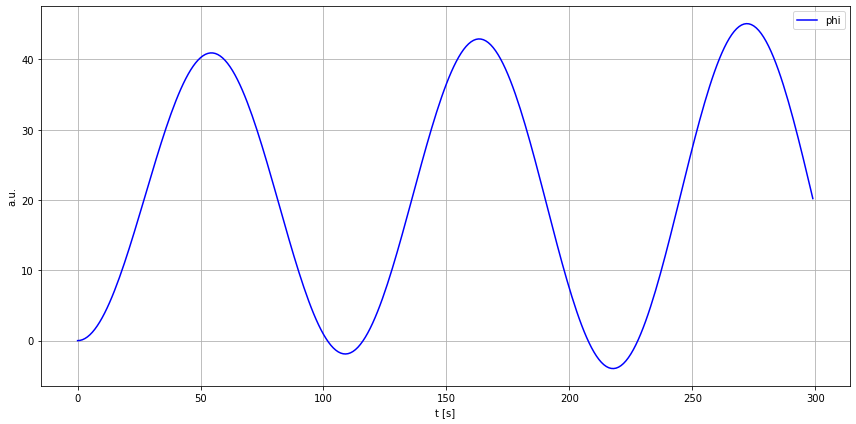

In [6]:
start=0
t = results[start:,0]
y = results[start:,1]
z = results[start:,2]
phi = results[start:,3]
dphi = results[start:,6]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(np.rad2deg(phi), 'b', label="phi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

We can see that the drone angle is oscillation around the set point `phi0'. You should play with the proportional gain ```p``` to see how the behaviour of the loop changes with the gain.

Even without knowing much about PID controllers, we can guess that our feedback loop is missing a **damping** term. This is something we can add easily, because the drone reports its velocity.

## Proportional feedback with damping

In [7]:
# Damped proportional feedback
def phi_damped_feedback(phi, dphi, phi0):
    p =  5
    d =  1
    fb = (phi-phi0) * p + d * dphi
    return fb

/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
drone = module.Drone(name=MyName, wind=True, flight_range=[0,0,0,0])


/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


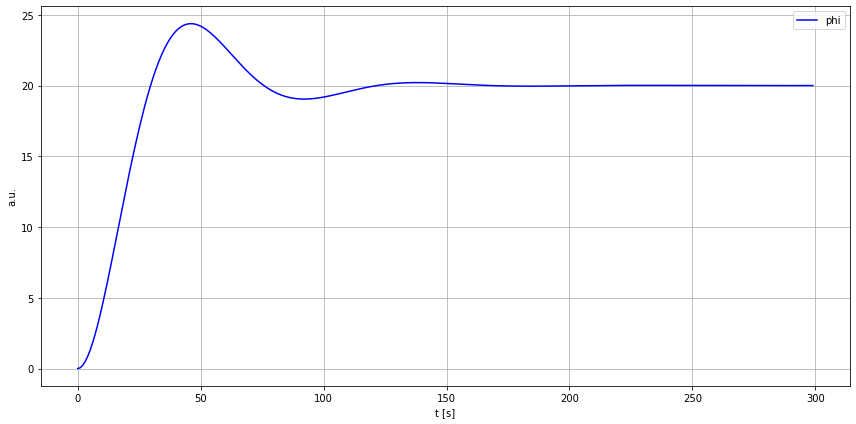

In [9]:
# testing our new feedback function

drone = module.Drone(name=MyName, wind=True, flight_range=[0,0,0,0])
N = 300 
results = np.zeros([N,14])
V_left=0
V_right=0
phi0=np.deg2rad(20)
set_v(drone,V_left,V_right)

for i in range(N):
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right]
    phi = results[i,3]
    dphi = results[i,6]
    phi_fb = phi_damped_feedback(phi,dphi, phi0)
    V_left, V_right = zphi2V(0, phi_fb)
    set_v(drone,V_left, V_right)

start=0
t = results[start:,0]
y = results[start:,1]
z = results[start:,2]
phi = results[start:,3]
dphi = results[start:,6]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(np.rad2deg(phi), 'b', label="phi")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

Much better! The control can be optimised by changed the two gains ```p``` and ```d``` such that the drone reaches the set point ```phi0``` in the shortest amount of time without any overshoot. This is similar to applying critical damping in an oscillator.

With this loop we can already achieve a very good response of the drone. For this loop there is no apparent need to add an **integrator** (the `I' in PID). However, we will see where this could be usefil in the vertical control below.

# Vertical control

Next we want to design a loop that holds the drone at a set vertical position ```z0```. We already know that we need at least a damped feedback function. We can relax the clamping of the drone by using a ```flight_range``` of ```[0, -500, 0, 500]``` which allows the drone up and down but no sideways motion. We must keep the tilt control enaged however. Make sure to experiment with large values for ```z0```.

In [10]:
# REMEMBER! phi faster than Y

# tilt feedback loop
def phi_damped_feedback(phi, dphi, phi0):
    p =  10
    d =  2

    fb = (phi-phi0) * p + d * dphi
    return fb

# vertical feedback loop
def z_damped_feedback(z, dz, z0):
    p =  -2
    d =  1
    fb = (z-z0) * p - d * dz
    return fb


/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


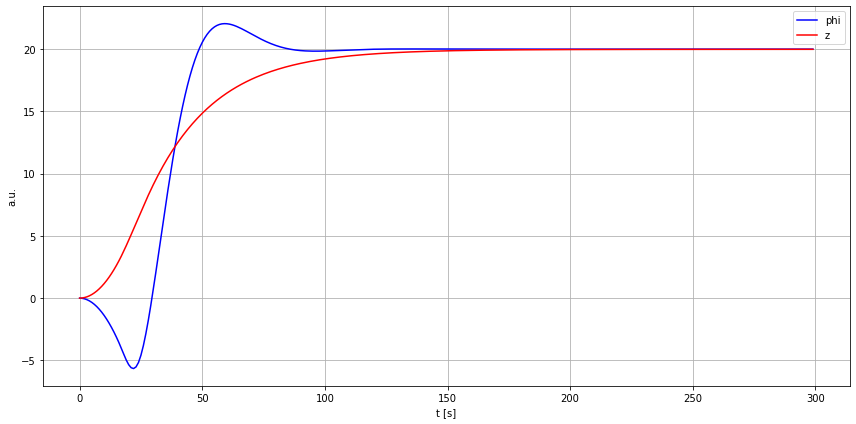

In [11]:
drone = module.Drone(name=MyName, wind=True, flight_range=[0,-500,0,500])
# testing our new feedback function
N = 300 
results = np.zeros([N,14])
V_left=0
V_right=0
phi0=np.deg2rad(20)
z0 = 20
set_v(drone,V_left,V_right)

for i in range(N):
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right]
    phi = results[i,3]
    dphi = results[i,6]
    z= results[i,2]
    dz = results[i,5]
    phi_fb = phi_damped_feedback(phi,dphi, phi0)
    z_fb = z_damped_feedback(z, dz, z0)
    V_left, V_right = zphi2V(z_fb, phi_fb)
    
    set_v(drone,V_left, V_right)

start=0
t = results[start:,0]
y = results[start:,1]
z = results[start:,2]
phi = results[start:,3]
dphi = results[start:,6]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(np.rad2deg(phi), 'b', label="phi")
plt.plot(z, 'r', label="z")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

After playing around with the gains you should be able to control the z position quickly, similar to the angle above.

The next part is optional. If you want, you can also go directly to the next part: `cascaded control`.

# Optional: integrator control 
If you want to explore more control options, the vertical control can be a good example for the testing the integretor part in a control loop. Use the alternative ```set_vnohover``` function that does not include the ```V_hover``` offset and then run the same control function again:

In [12]:
def set_v_nohover(drone, _V_left, _V_right):
    V_left =  np.clip(_V_left + V_left_offset, V_min, V_max)
    V_right = np.clip(_V_right, V_min, V_max)
    drone.set_V(V_left, V_right)

/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
drone = module.Drone(name=MyName, wind=True, flight_range=[0,-500,0,500])


/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


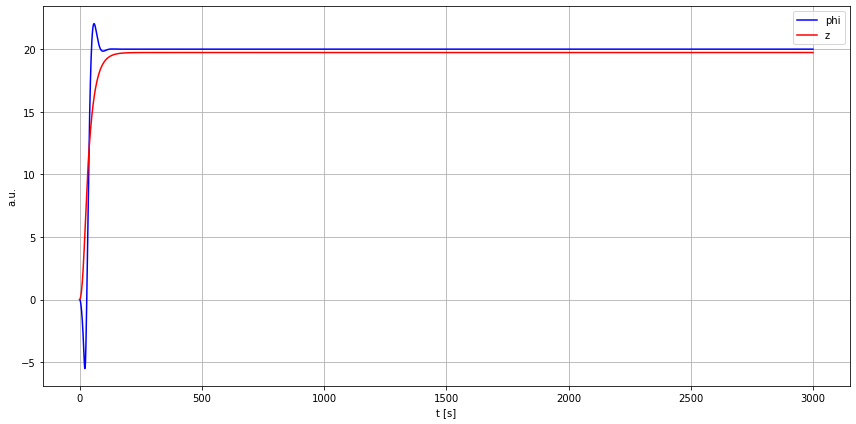

In [14]:

# testing our new feedback function
N = 3000
results = np.zeros([N,14])
V_left=0
V_right=0
phi0=np.deg2rad(20)
z0 = 20
set_v(drone,V_left,V_right)

for i in range(N):
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right]
    phi = results[i,3]
    dphi = results[i,6]
    z= results[i,2]
    dz = results[i,5]
    phi_fb = phi_damped_feedback(phi,dphi, phi0)
    z_fb = z_damped_feedback(z, dz, z0)
    V_left, V_right = zphi2V(z_fb, phi_fb)
    
    set_v_nohover(drone,V_left, V_right)

start=0
t = results[start:,0]
y = results[start:,1]
z = results[start:,2]
phi = results[start:,3]
dphi = results[start:,6]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(np.rad2deg(phi), 'b', label="phi")
plt.plot(z, 'r', label="z")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

At first glance the result looks the same, but if we zoom into the plot when the set point has apparently been reached, we see that we never actually reach the set point. This is simply because the feedback is proportional to the error signal ```z-z0```, which goes to zero when we approach the set point, and when close enough becomes too small to overcome the gravitational acceleration. 

/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


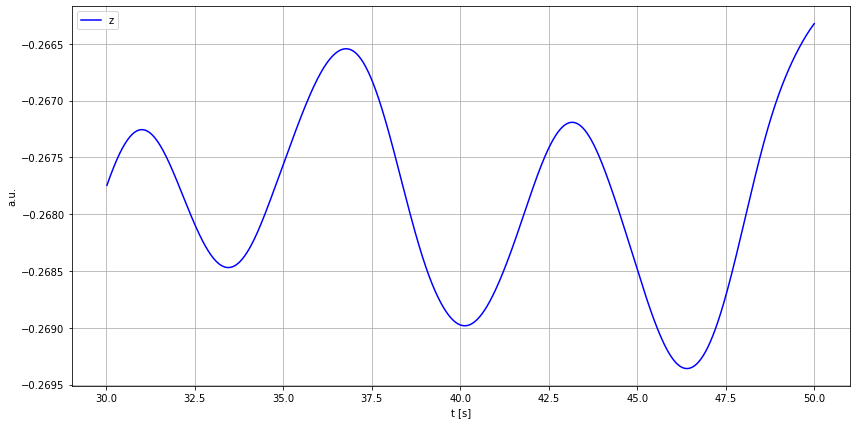

In [15]:
# Zoom into the resdiuals for example like this:
start=1800
t = results[start:,0]
y = results[start:,1]
z = results[start:,2]
dz = results[start:,5]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(t, z-z0, 'b', label="z")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

In such a case we can add an integrator to the feedback loop:

In [16]:
# vertical feedback loop
def z_PID_feedback(z, dz, z0, z_fb):
    # z: z position of drone
    # dz: z velocity of drone
    # z0 : set point
    # z_fb: previously returned feedback
    p =  -2
    d =  1
    i = 0.92  # integrator gain
    fb = (z-z0) * p - d * dz + i*z_fb
    return fb

/home/joran/miniconda3/envs/strax/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Try the done with the new feeback, and also check the residuals

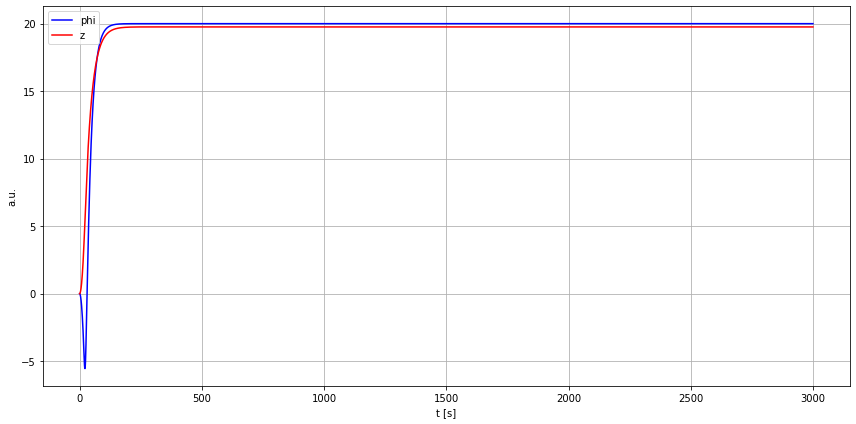

In [25]:
drone = module.Drone(name=MyName, wind=True, flight_range=[0,-500,0,500])
# testing our new feedback function
N = 3000
results = np.zeros([N,14])
V_left=0
V_right=0
phi0=np.deg2rad(20)
z0 = 20
set_v(drone,V_left,V_right)
# first should be 0
z_fb=0

for i in range(N):
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right]
    phi = results[i,3]
    dphi = results[i,6]
    z= results[i,2]
    dz = results[i,5]
    phi_fb = phi_damped_feedback(phi,dphi, phi0)
    z_fb = z_PID_feedback(z, dz, z0, z_fb)
    V_left, V_right = zphi2V(z_fb, phi_fb)
    
    set_v_nohover(drone,V_left, V_right)

start=0
t = results[start:,0]
y = results[start:,1]
z = results[start:,2]
phi = results[start:,3]
dphi = results[start:,6]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(np.rad2deg(phi), 'b', label="phi")
plt.plot(z, 'r', label="z")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()


After fine-tuning the gains, we can get much closer to the set point (however, we cannot really reach it, the residual will be always >0). The integrator part is useful in controls with a constant or low-frequency disturbance, such as, in this case, the constat graviational force.

# Horizontal control, we need a cascaded system!

Now to complete the controller we need to add a horizontal control loop. However we have no actuator that can move the drone sideways directly. Instead we need to tilt the drone to create a sideways motion. Therefore the tilt control loop can be our actuator for the horizontal control. This means a cascaded system, in which the horizontal control is an `outer loop' and the tilt control the `inner loop'.

To test this we write yet another feedback loop, using at least proportional and differential feedback. We then use the feedback from that loop to change the set point of the tilt control loop. 

For this part we need to open up the drone ```flight_range``` to the full field of ```[-500, -500, 500, 500]```.


In [45]:
# vertical feedback loop
def z_PID_feedback(z, dz, z0, z_fb):
    # z: z position of drone
    # dz: z velocity of drone
    # z0 : set point
    # z_fb: previously returned feedback
    p =  -2
    d =  1
    i = 0.1  # integrator gain
    fb = (z-z0) * p - d * dz + i*z_fb
    return fb

# phi faster than y!!
def phi_damped_feedback(phi, dphi, phi0):
    p =  0
    d =  0

    fb = (phi-phi0) * p + d * dphi
    return fb


def y_PID_feedback(y, dy, y0, y_fb):
    p = 1
    d = .9
    i = 0.1
    fb = (y-y0) * p + d * dy + i * y_fb
    # we limit the tilt the drone no more that +-0.2 pi
    fb = np.clip(fb, -0.2*np.pi, 0.2*np.pi)
    return fb

In [42]:
def xyphi2V(z_fb, phi_fb, y_fb):
    a,b = zphi2V(z_fb, phi_fb)
    return a, b+y

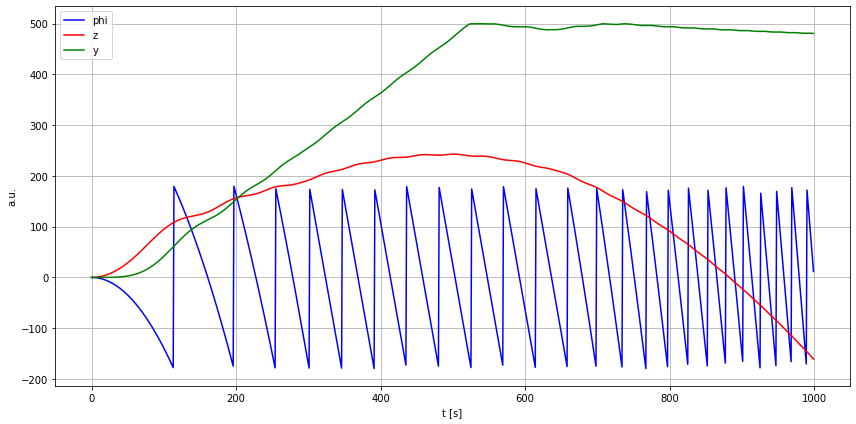

In [44]:
# drone = module.Drone(name=MyName, wind=True, flight_range=[0,-500,0,500])
drone = module.Drone(name=MyName, wind=True, flight_range=[-500,-500,500,500])
# testing our new feedback function
N = 1000
results = np.zeros([N,14])
V_left=0
V_right=0
phi0=np.deg2rad(20)
z0 = 200
y0 = 300
set_v(drone,V_left,V_right)
# first should be 0
z_fb=0
y_fb=0
phi_fb=0
start =0
for i in range(N):
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right]
    
    
    y= results[i,1]
    z= results[i,2]
    phi = results[i,3]
    dy= results[i,4]
    dz = results[i,5]
    dphi = results[i,6]
    y_fb  = y_PID_feedback(y, dy, y0, y_fb)
    phi_fb = phi_damped_feedback(phi, dphi, y_fb)
    z_fb = z_PID_feedback(z, dz, z0, z_fb)
    
    V_left, V_right = zphi2V(z_fb, phi_fb)
    
    set_v_nohover(drone, V_left, V_right)


t = results[start:,0]
y = results[start:,1]
z = results[start:,2]
phi = results[start:,3]
dphi = results[start:,6]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(np.rad2deg(phi), 'b', label="phi")
plt.plot(z, 'r', label="z")
plt.plot(y, 'green', label="y")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

We can see that the naive combination of the feedback through the function ```zphi2V(fb_z, fb_phi)``` we created at the very top of the notebook works. But if you experiment a bit more you can also see that it has a few problems. For example, in certain conditions we can see in the flight behaviour that the direction of ```phi``` set by the y control is wrong when the vertial feedback is negativ. Similarly, the clipping of the voltage can cancel the tilt when the amount of vertical feedback is large. To address these issues you could try smarter combination. 

In the next notebooks we will use the control loops designed here. The naive signal combination and clipping will give satisfactory results. We suggest trying these first before you think about optimised control designs.  

In [49]:
drone = module.Drone(name=MyName, wind=True, flight_range=[0,-500,0,500])
# testing our new feedback function
N = 3000
results = np.zeros([N,14])
V_left=0
V_right=0
phi0=np.deg2rad(20)
z0 = 20
set_v(drone,V_left,V_right)
# first should be 0
z_fb=0
y_fb = 0

for i in range(N):
    results[i,0:12] = drone.update()
    results[i,12:14] = [V_left,V_right]
    phi = results[i,3]
    dphi = results[i,6]
    z= results[i,2]
    dz = results[i,5]
    y_fb = y_PID_feedback(y, dy, y0, y_fb)
    phi_fb = phi_damped_feedback(phi,dphi, y_fb)
    z_fb = z_PID_feedback(z, dz, z0, z_fb)
    V_left, V_right = zphi2V(z_fb, phi_fb)
    
    set_v_nohover(drone,V_left, V_right)

start=0
t = results[start:,0]
y = results[start:,1]
z = results[start:,2]
phi = results[start:,3]
dphi = results[start:,6]
fig, ax = plt.subplots(1, figsize=(12,6))
plt.plot(np.rad2deg(phi), 'b', label="phi")
plt.plot(z, 'r', label="z")
ax.set_xlabel("t [s]")
ax.set_ylabel("a.u.")
plt.grid()
plt.legend()
plt.tight_layout()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.